In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt 

from ekarus.e2e.cascading_stage_ao_class import CascadingAO
from ekarus.e2e.single_stage_ao_class import SingleStageAO

from ekarus.e2e.utils import my_fits_package as myfits
from ekarus.e2e.utils.image_utils import reshape_on_mask

import os.path as op


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
prf = 'mag7_'
cascao = CascadingAO(tn='cascading_8m_Mic')
ma_atmo_phases, _, res1_phases, det1_frames, rec1_modes, dm1_cmds, _, res2_phases, det2_frames, rec2_modes, dm2_cmds = cascao.load_telemetry_data(save_prefix=prf)
KL1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_KLmodes.fits'))
KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KLmodes.fits'))

In [3]:

# KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_KLmodes.fits'))
# phase2modes = xp.linalg.pinv(KL.T)

# def get_modes(ma,id):
#     im_data = ma[id].data
#     phase = xp.array(im_data[~ma[id].mask])
#     ph_rms = xp.sqrt(xp.sum(phase**2)/len(phase))
#     modes = phase2modes @ phase
#     rec_phase = KL.T @ modes
#     rec_phase_2d = reshape_on_mask(rec_phase, xp.asarray(ma[id].mask))
#     rec_ma = masked_array(xp.asnumpy(rec_phase_2d), ma[id].mask)
#     return modes, rec_ma, ph_rms

In [4]:
# atmo_modes, rec_atmo, atmo_rms = get_modes(ma_atmo_phases,-1)
# res1_modes, rec_ph1, res1_rms = get_modes(res1_phases,-1)
# res2_modes, rec_ph2, res2_rms = get_modes(res2_phases,-1)

# print(xp.sum(xp.abs(atmo_modes)),xp.sum(xp.abs(res1_modes)),xp.sum(xp.abs(res2_modes)))
# print(xp.sum(xp.abs(atmo_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res1_modes)*xp.std(KL.T,axis=0)),xp.sum(xp.abs(res2_modes)*xp.std(KL.T,axis=0)))
# print(atmo_rms, res1_rms, res2_rms)

In [5]:
# mask = cascao.cmask.copy()
# # m2c1 = myfits.read_fits(op.join(cascao.savecalibpath,'DM1_m2c.fits'))
# # m2c2 = myfits.read_fits(op.join(cascao.savecalibpath,'DM2_m2c.fits'))

# # c2m1 = xp.linalg.pinv(m2c1[:rec1_modes.shape[1],:])
# # c2m2 = xp.linalg.pinv(m2c2[:rec2_modes.shape[1],:])

# # rec1_kls = c2m1 @ rec1_modes[-1]
# rec1_phase = KL[:rec1_modes.shape[1],:].T @ rec1_modes[-1]
# rec1_phase_2d = reshape_on_mask(rec1_phase, mask)
# rec1_ma = masked_array(xp.asnumpy(rec1_phase_2d), xp.asnumpy(mask))
# # rec2_kls = c2m2 @ rec2_modes[-1]
# rec2_phase = KL2[:rec2_modes.shape[1],:].T @ rec2_modes[-1]
# rec2_phase_2d = reshape_on_mask(rec2_phase, mask)
# rec2_ma = masked_array(xp.asnumpy(rec2_phase_2d), xp.asnumpy(mask))

In [6]:
# plt.figure(figsize=(16,12))
# plt.subplot(3,3,1)
# plot_masked_array(ma_atmo_phases,-1)
# plt.subplot(3,3,2)
# plot_masked_array(res1_phases,-1)
# plt.subplot(3,3,3)
# plot_masked_array(res2_phases,-1)
# plt.subplot(3,3,4)
# plot_masked_array(rec_atmo)
# plt.subplot(3,3,5)
# plot_masked_array(rec_ph1)
# plt.subplot(3,3,6)
# plot_masked_array(rec_ph2)
# plt.subplot(3,3,8)
# plot_masked_array(rec1_ma)
# plt.subplot(3,3,9)
# plot_masked_array(rec2_ma)

In [7]:
def plot_masked_array(ma, id=None, mask=None):
    if mask is not None:
        img = reshape_on_mask(ma[id],mask)
        marray = masked_array(xp.asnumpy(img), xp.asnumpy(mask))
    else:
        ma_id = ma.copy()
        if id is not None:
            ma_id = ma[id]
        marray = masked_array(ma_id.data,mask=ma_id.mask)
    plt.imshow(marray,origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')


def filter_modes(atmo_phases, KL, nModes2Filter, coeff=1.0):
    MM = KL[:nModes2Filter,:]
    phase2modes = xp.linalg.pinv(MM.T)
    modes = phase2modes @ atmo_phases.T
    rec_phases = MM.T @ modes
    rec_phases *= coeff
    filt_phases = atmo_phases.T - rec_phases
    return filt_phases.T


def masked_array_to_matrix(ma_vec, mask):
    N = xp.shape(ma_vec)[0]
    data_len = int(xp.sum(1-mask))
    mat = xp.zeros([N,data_len])
    for i in range(N):
        mat[i,:] = xp.asarray(ma_vec[i].data)[~mask]
    return mat

In [8]:
def simulate_cascading_performance(atmo_phases, nModes_1st_stage:int, correction_1st_stage:float, 
                                   nModes_2nd_stage:int, correction_2nd_stage:float,
                                   normalize_to_perfect_psf:bool = True,
                                   lambdaRef:float=750e-9, Nframes:int=128, use_avg_field:bool=True,
                                   ):
    
    filt_phases_1st_stage = filter_modes(atmo_phases, KL1, nModes_1st_stage, coeff=correction_1st_stage)
    filt_phases_2nd_stage = filter_modes(filt_phases_1st_stage, KL2, nModes_2nd_stage, coeff=(1-(1-correction_2nd_stage)/(1-correction_1st_stage)))
    filt_phases_perfect_stage = filter_modes(atmo_phases, KL1, max(nModes_1st_stage,nModes_2nd_stage))

    atmo_phases_in_rad = atmo_phases[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_1st_in_rad = filt_phases_1st_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_2nd_in_rad = filt_phases_2nd_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_perf_in_rad = filt_phases_perfect_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef

    _, atmo_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage1_profile, pix_dist = cascao.get_contrast(filt_1st_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage2_profile, pix_dist = cascao.get_contrast(filt_2nd_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, perf_stage_profile, pix_dist = cascao.get_contrast(filt_perf_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

    plt.figure()
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(atmo_profile), label='atmo')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage1_profile), label=f'1st stage: {nModes_1st_stage:1.0f} modes @ {correction_1st_stage*1e+2:1.0f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage2_profile), label=f'2nd stage: {nModes_2nd_stage:1.0f} modes @ {correction_2nd_stage*1e+2:1.1f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(perf_stage_profile), label=f'perfect stage: {nModes_1st_stage:1.0f} modes @ 100%')
    plt.legend()
    plt.grid()
    plt.xlim([0,24])
    plt.ylim([1e-7,1e-2])
    plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
    plt.xlabel(r'$\lambda/D$')
    plt.yscale('log')
    plt.title('Contrast with perfect coronograph\nand partial correction')

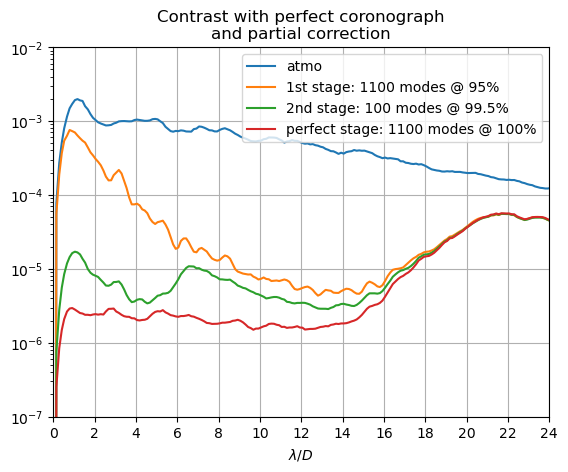

In [27]:
atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=1100, correction_1st_stage=0.95, nModes_2nd_stage=100, correction_2nd_stage=0.995)

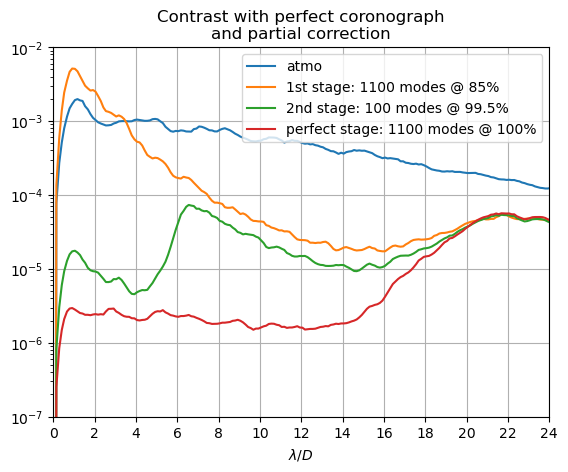

In [31]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=1100, correction_1st_stage=0.85, nModes_2nd_stage=100, correction_2nd_stage=0.995)

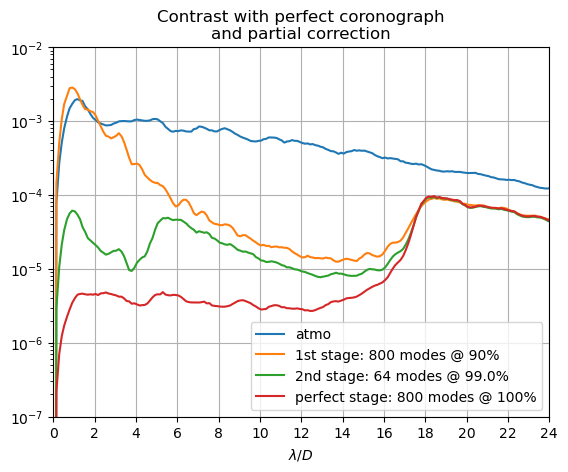

In [23]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=800, correction_1st_stage=0.9, nModes_2nd_stage=64, correction_2nd_stage=0.99)

In [12]:
lambdaRef = 750e-9
N = 128

filt1100_phases = filter_modes(atmo_phases, KL1, 1100)
atmo_phases_in_rad = atmo_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt1100_phases_in_rad = filt1100_phases[-N:,:] * (2*xp.pi)/lambdaRef

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8)

Initializing devices ...
File /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/f4kHz_atmo_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/atmo_phases.fits instead
File /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/f4kHz_dm_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/dm_phases.fits instead
File /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/f4kHz_residual_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/residual_phases.fits instead
File /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/f4kHz_ccd_frames.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/ccd_frames.fits instead
File /home/matte/git/ekarus/ekarus/simulations/results/cascading_8m_ssao_ref/f4kHz_reconstructor_modes.fits not f

Text(0.5, 1.0, 'Contrast @ 750nm\nSingle stage, perfect coronograph')

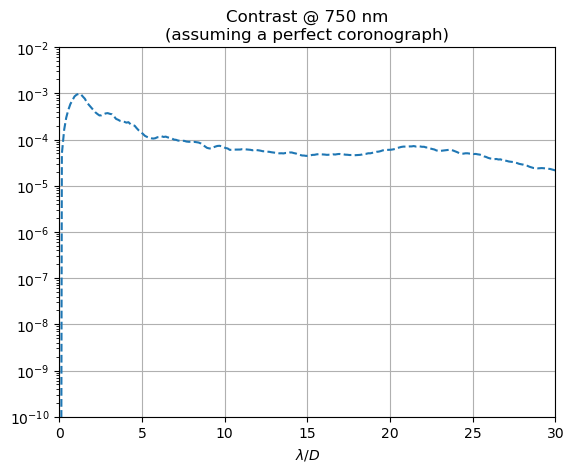

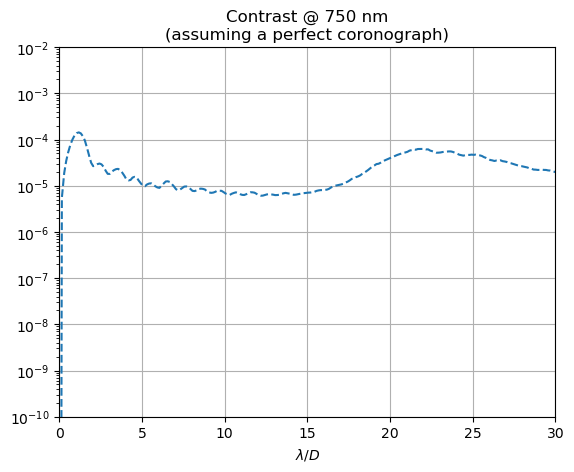

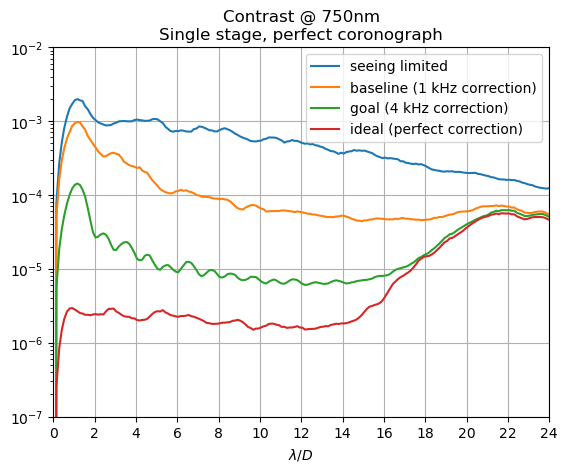

In [13]:
ssao = SingleStageAO(tn='cascading_8m_ssao_ref')
psf1, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f1kHz_', oversampling=8)
psf2, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f4kHz_', oversampling=8)
plt.figure()
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='seeing limited')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf1), label='baseline (1 kHz correction)')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf2), label='goal (4 kHz correction)')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='ideal (perfect correction)')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast @ 750nm\nSingle stage, perfect coronograph')

In [14]:

# atmo_noTT_phases = filter_modes(atmo_phases, KL1, 2)
filt10_phases = filter_modes(atmo_phases, KL1, 10)
filt100_phases = filter_modes(atmo_phases, KL1, 100)
filt200_phases = filter_modes(atmo_phases, KL1, 200)
filt800_phases = filter_modes(atmo_phases, KL1, 800)

In [15]:

# filt5_phases_in_rad = filt5_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt10_phases_in_rad = filt10_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt100_phases_in_rad = filt100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt200_phases_in_rad = filt200_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt800_phases_in_rad = filt800_phases[-N:,:] * (2*xp.pi)/lambdaRef

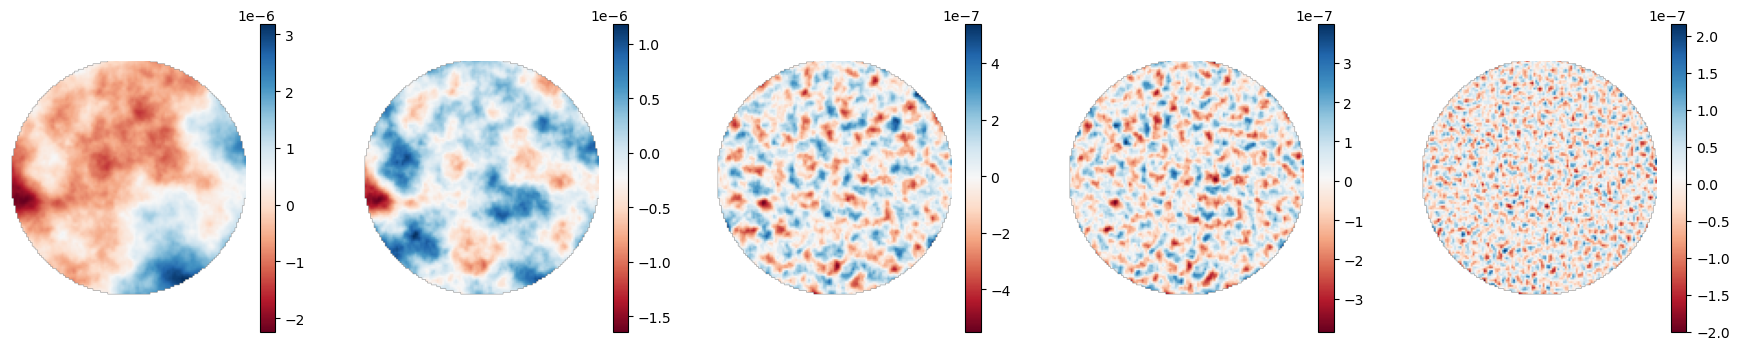

In [16]:
plt.figure(figsize=(22,4))
plt.subplot(1,5,1)
plot_masked_array(atmo_phases,-1, cascao.cmask)
plt.subplot(1,5,2)
plot_masked_array(filt10_phases,-1, cascao.cmask)
plt.subplot(1,5,3)
plot_masked_array(filt100_phases,-1, cascao.cmask)
plt.subplot(1,5,4)
plot_masked_array(filt200_phases,-1, cascao.cmask)
plt.subplot(1,5,5)
plot_masked_array(filt800_phases,-1, cascao.cmask)

In [17]:
normalize_to_perfect_psf = True
use_avg_field = False

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

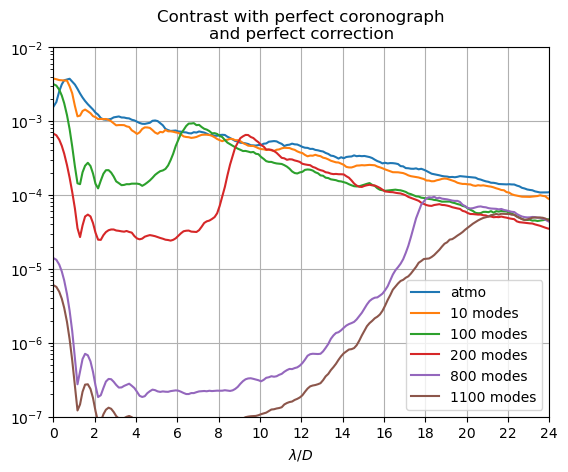

In [18]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [19]:
normalize_to_perfect_psf = True
use_avg_field = True

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

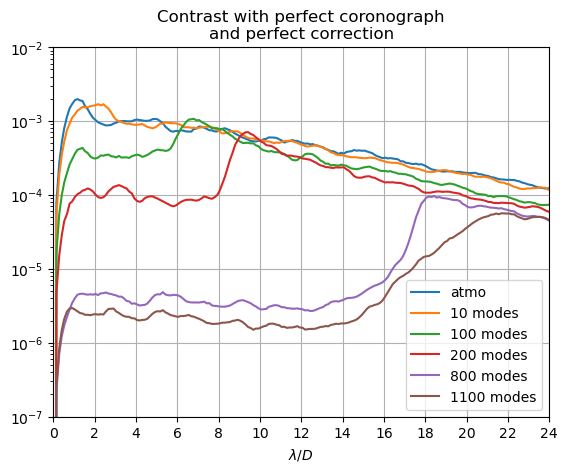

In [20]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [21]:
N = 1100
n_act = xp.sqrt(4/xp.pi*N)
print(n_act/2, xp.sqrt(4/xp.pi), xp.sqrt(N)/2)

18.712051592547777 1.1283791670955126 16.583123951777
